In [1]:
import os
import numpy as np
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet152,ResNet50,VGG19,InceptionV3,MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score

In [2]:
def load_images_from_folder(base_path,subpath):
    datasets = {'healthy': {'images': [], 'labels': []},
                'parkinson': {'images': [], 'labels': []}}
    
    for dataset in ['testing', 'training']:
        dataset_path = os.path.join(base_path, subpath, dataset)
        
        for class_label, class_folder in enumerate(['healthy', 'parkinson']):
            class_path = os.path.join(dataset_path, class_folder)
            
            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    
                    try:
                        with Image.open(img_path) as img:
                            img = img.convert('RGB')
                            img = img.resize((224, 224))  # Adjust size as needed
                            img_array = np.array(img)
                            datasets[class_folder]['images'].append(img_array)
                            datasets[class_folder]['labels'].append(class_label)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    for dataset in datasets:
        datasets[dataset]['images'] = np.array(datasets[dataset]['images'])
        datasets[dataset]['labels'] = np.array(datasets[dataset]['labels'])
    
    return datasets


In [3]:
# Usage
base_path = 'D:\Projects\Parkinsons_disease\image_model_v2\data'
datasets_spiral = load_images_from_folder(base_path,'wave')

# Access healthy and parkinson data separately
X_healthy_wave, y_healthy_wave = datasets_spiral['healthy']['images'], datasets_spiral['healthy']['labels']
X_parkinson_wave, y_parkinson_wave = datasets_spiral['parkinson']['images'], datasets_spiral['parkinson']['labels']

print(f"Loaded {len(X_healthy_wave)} healthy images and {len(X_parkinson_wave)} parkinson images of spiral")
print(f"Image shape: {X_healthy_wave[0].shape}")
print(f"Number of classes: {len(np.unique(np.concatenate([y_healthy_wave, y_parkinson_wave])))}")

Loaded 51 healthy images and 51 parkinson images of spiral
Image shape: (224, 224, 3)
Number of classes: 2


In [4]:
X = np.concatenate([X_healthy_wave,X_parkinson_wave],axis=0)
y = np.concatenate([y_healthy_wave,y_parkinson_wave],axis=0)
print(f"{X.shape},{y.shape}")

(102, 224, 224, 3),(102,)


In [5]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=0)

In [6]:
print(f"train shape : {x_train.shape},{y_train.shape}")
print(f"val shape   : {x_val.shape},{y_val.shape}")
print(f"test shape  : {x_test.shape},{y_test.shape}")

train shape : (72, 224, 224, 3),(72,)
val shape   : (9, 224, 224, 3),(9,)
test shape  : (21, 224, 224, 3),(21,)


# ResNet152

In [7]:
base_model = ResNet152(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

resnet152_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
resnet152_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
history = resnet152_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 28s 3s/step - loss: 0.5508 - accuracy: 0.7639 - val_loss: 0.2584 - val_accuracy: 1.0000
Epoch 2/100
6/6 [==============================] - 14s 2s/step - loss: 0.3061 - accuracy: 0.8750 - val_loss: 0.2001 - val_accuracy: 0.8889
Epoch 3/100
6/6 [==============================] - 14s 2s/step - loss: 0.2406 - accuracy: 0.9028 - val_loss: 0.1049 - val_accuracy: 1.0000
Epoch 4/100
6/6 [==============================] - 13s 2s/step - loss: 0.1998 - accuracy: 0.9583 - val_loss: 0.0880 - val_accuracy: 1.0000
Epoch 5/100
6/6 [==============================] - 12s 2s/step - loss: 0.1721 - accuracy: 0.9306 - val_loss: 0.0863 - val_accuracy: 1.0000
Epoch 6/100
6/6 [==============================] - 12s 2s/step - loss: 0.1518 - accuracy: 0.9444 - val_loss: 0.0717 - val_accuracy: 1.0000
Epoch 7/100
6/6 [==============================] - 11s 2s/step - loss: 0.1326 - accuracy: 0.9722 - val_loss: 0.0755 - val_accuracy: 1.0000
Epoch 8/100
6/6 [==========

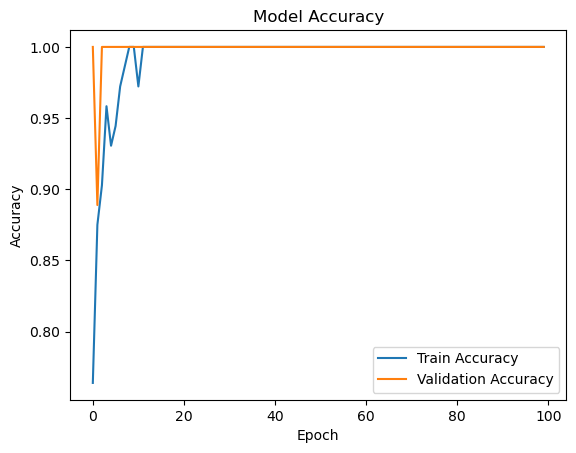

In [9]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

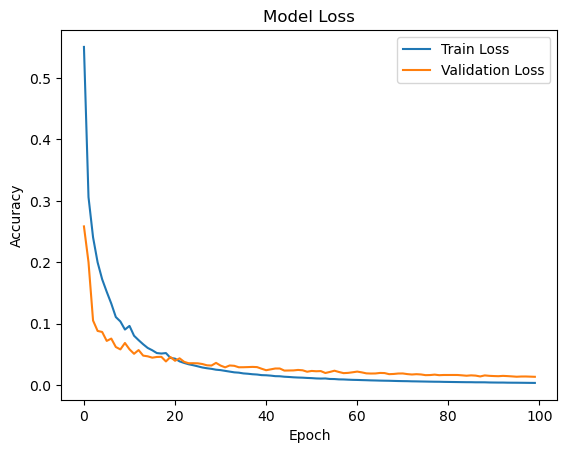

In [10]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ResNet50

In [11]:
base_model = ResNet50(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

resnet50_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history = resnet50_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.7371 - accuracy: 0.5833

6/6 [==============================] - 14s 995ms/step - loss: 0.7371 - accuracy: 0.5833 - val_loss: 0.4058 - val_accuracy: 0.7778
Epoch 2/100
6/6 [==============================] - 3s 459ms/step - loss: 0.5101 - accuracy: 0.7361 - val_loss: 0.3720 - val_accuracy: 0.7778
Epoch 3/100
6/6 [==============================] - 3s 464ms/step - loss: 0.4064 - accuracy: 0.8056 - val_loss: 0.2078 - val_accuracy: 0.8889
Epoch 4/100
6/6 [==============================] - 3s 464ms/step - loss: 0.3009 - accuracy: 0.8889 - val_loss: 0.1540 - val_accuracy: 1.0000
Epoch 5/100
6/6 [==============================] - 3s 465ms/step - loss: 0.2777 - accuracy: 0.9167 - val_loss: 0.1422 - val_accuracy: 1.0000
Epoch 6/100
6/6 [==============================] - 3s 482ms/step - loss: 0.2349 - accuracy: 0.8750 - val_loss: 0.1453 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 3s 454ms/step - loss: 0.2211 - accuracy: 0.9028 - val_loss: 0.1283 - val_accuracy: 1.0000
Epoch 8/100
6/6 [=======

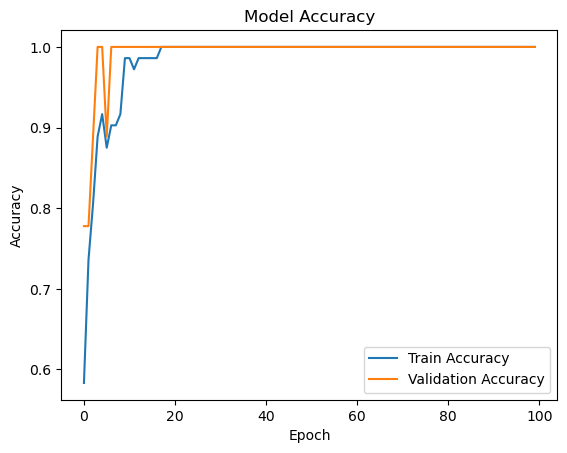

In [13]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

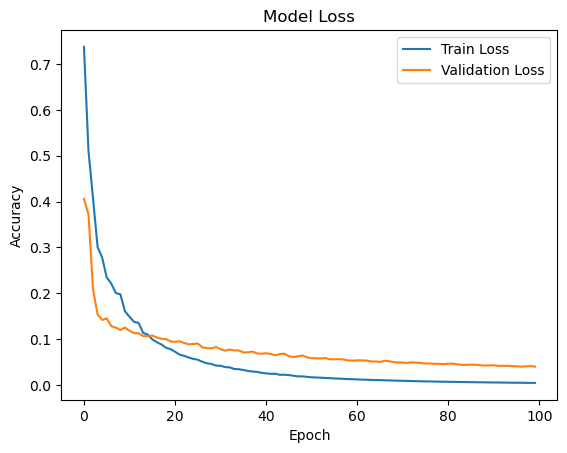

In [14]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# VGG19

In [15]:
base_model = VGG19(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

vgg_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history = vgg_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 10s 1s/step - loss: 0.7973 - accuracy: 0.5694 - val_loss: 0.8951 - val_accuracy: 0.5556
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 0.5560 - accuracy: 0.7500 - val_loss: 0.3190 - val_accuracy: 0.8889
Epoch 3/100
6/6 [==============================] - 8s 1s/step - loss: 0.4364 - accuracy: 0.7639 - val_loss: 0.2322 - val_accuracy: 0.8889
Epoch 4/100
6/6 [==============================] - 8s 1s/step - loss: 0.3031 - accuracy: 0.8611 - val_loss: 0.3264 - val_accuracy: 0.7778
Epoch 5/100
6/6 [==============================] - 9s 1s/step - loss: 0.2956 - accuracy: 0.8750 - val_loss: 0.3081 - val_accuracy: 0.7778
Epoch 6/100
6/6 [==============================] - 8s 1s/step - loss: 0.2476 - accuracy: 0.9028 - val_loss: 0.1896 - val_accuracy: 1.0000
Epoch 7/100
6/6 [==============================] - 9s 2s/step - loss: 0.2195 - accuracy: 0.9167 - val_loss: 0.2446 - val_accuracy: 0.7778
Epoch 8/100
6/6 [================

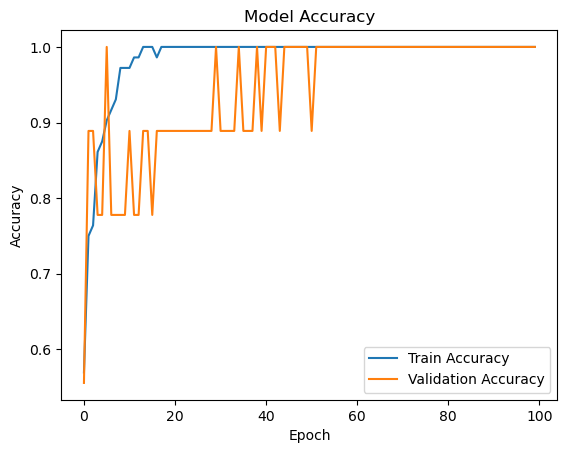

In [17]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

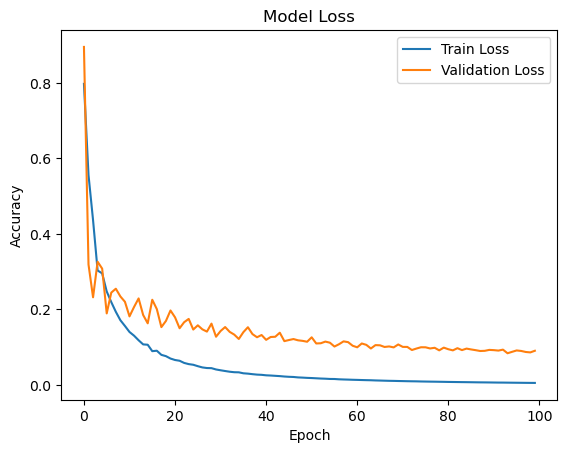

In [18]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# InceptionNet

In [19]:
base_model = InceptionV3(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

inception_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
inception_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
history = inception_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 9s 715ms/step - loss: 5.0798 - accuracy: 0.4583 - val_loss: 0.4435 - val_accuracy: 0.7778
Epoch 2/100
6/6 [==============================] - 2s 271ms/step - loss: 1.7512 - accuracy: 0.6528 - val_loss: 0.1351 - val_accuracy: 0.8889
Epoch 3/100
6/6 [==============================] - 1s 252ms/step - loss: 0.7692 - accuracy: 0.7500 - val_loss: 0.1854 - val_accuracy: 0.8889
Epoch 4/100
6/6 [==============================] - 1s 243ms/step - loss: 0.5845 - accuracy: 0.8333 - val_loss: 0.2529 - val_accuracy: 0.7778
Epoch 5/100
6/6 [==============================] - 1s 259ms/step - loss: 1.0037 - accuracy: 0.6806 - val_loss: 0.2621 - val_accuracy: 0.8889
Epoch 6/100
6/6 [==============================] - 1s 248ms/step - loss: 0.7630 - accuracy: 0.7083 - val_loss: 0.2131 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 2s 267ms/step - loss: 0.3263 - accuracy: 0.8472 - val_loss: 0.0940 - val_accuracy: 1.0000
Epoch 8/100
6

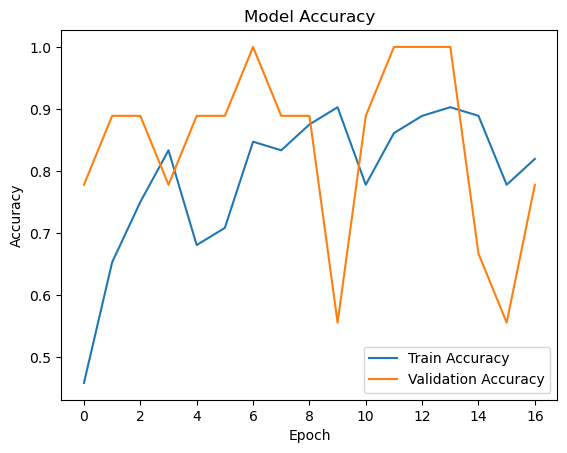

In [21]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

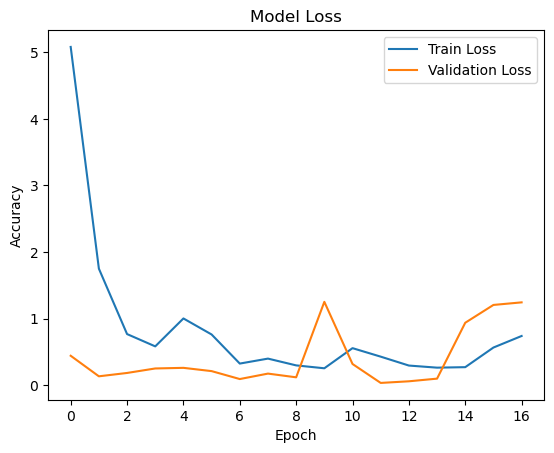

In [22]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# MobileNetv3

In [23]:
base_model = MobileNetV3Large(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
history = mobilenet_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 6s 486ms/step - loss: 0.7518 - accuracy: 0.5833 - val_loss: 0.6330 - val_accuracy: 0.5556
Epoch 2/100
6/6 [==============================] - 1s 135ms/step - loss: 0.5367 - accuracy: 0.7500 - val_loss: 0.4067 - val_accuracy: 0.7778
Epoch 3/100
6/6 [==============================] - 1s 129ms/step - loss: 0.4417 - accuracy: 0.8056 - val_loss: 0.3700 - val_accuracy: 0.7778
Epoch 4/100
6/6 [==============================] - 1s 132ms/step - loss: 0.3742 - accuracy: 0.8611 - val_loss: 0.3473 - val_accuracy: 0.7778
Epoch 5/100
6/6 [==============================] - 1s 132ms/step - loss: 0.3360 - accuracy: 0.8750 - val_loss: 0.3122 - val_accuracy: 0.8889
Epoch 6/100
6/6 [==============================] - 1s 128ms/step - loss: 0.3051 - accuracy: 0.8889 - val_loss: 0.3119 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 1s 127ms/step - loss: 0.2817 - accuracy: 0.8889 - val_loss: 0.2818 - val_accuracy: 0.8889
Epoch 8/100
6

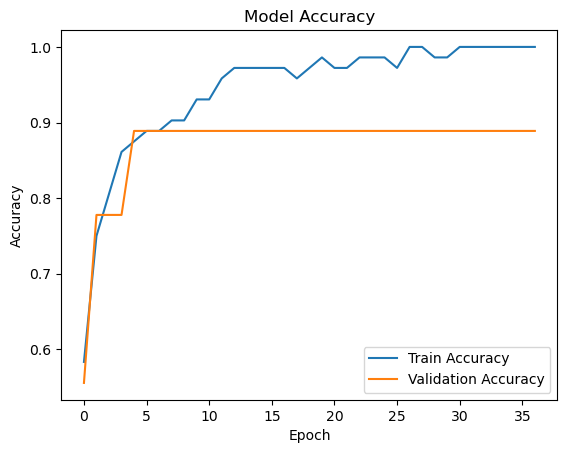

In [25]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

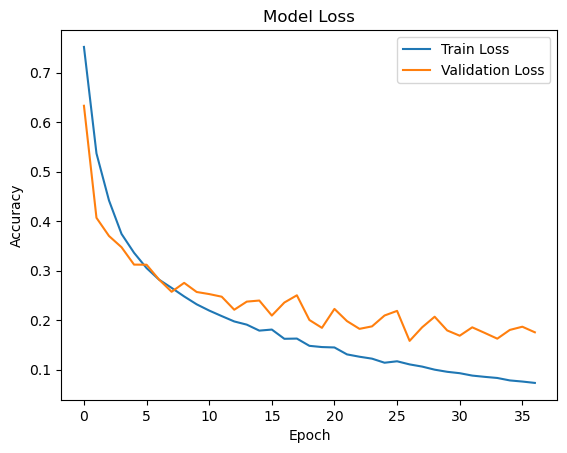

In [26]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Metrics

In [27]:
ypreds_resnet50 = resnet50_model.predict(x_test)
ypreds_resnet152 = resnet152_model.predict(x_test)
ypreds_mobilenet = mobilenet_model.predict(x_test)
ypreds_inception = inception_model.predict(x_test)
ypreds_vgg19 = vgg_model.predict(x_test)

1/1 [==============================] - 2s 2s/step


In [28]:
ypreds_resnet50 = np.where(ypreds_resnet50>=0.5,1,0) 
ypreds_resnet152 = np.where(ypreds_resnet152>=0.5,1,0)
ypreds_mobilenet = np.where(ypreds_mobilenet>=0.5,1,0)
ypreds_inception = np.where(ypreds_inception>=0.5,1,0)
ypreds_vgg19 =np.where(ypreds_vgg19>=0.5,1,0)

# Resnet50

In [29]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_resnet50)}")
print(f"Precision: {precision_score(y_test,ypreds_resnet50)}")
print(f"Recall: {recall_score(y_test,ypreds_resnet50)}")
print(f"F1 Score: {f1_score(y_test,ypreds_resnet50)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_resnet50)}")

Accuracy: 0.9047619047619048
Precision: 1.0
Recall: 0.8
F1 Score: 0.888888888888889
ROC Score: 0.9


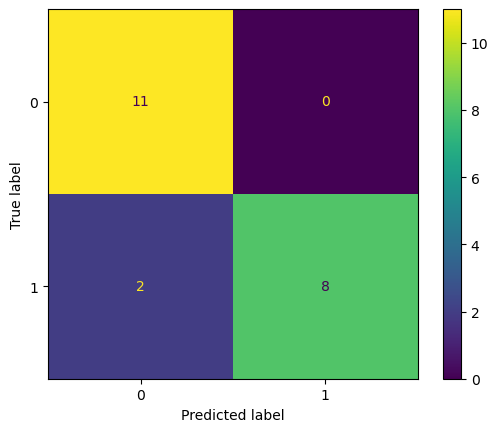

In [30]:
ConfusionMatrixDisplay(confusion_matrix(y_test,ypreds_resnet50)).plot()

# Resnet152

In [31]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_resnet152)}")
print(f"Precision: {precision_score(y_test,ypreds_resnet152)}")
print(f"Recall: {recall_score(y_test,ypreds_resnet152)}")
print(f"F1 Score: {f1_score(y_test,ypreds_resnet152)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_resnet152)}")

Accuracy: 0.9047619047619048
Precision: 0.9
Recall: 0.9
F1 Score: 0.9
ROC Score: 0.9045454545454544


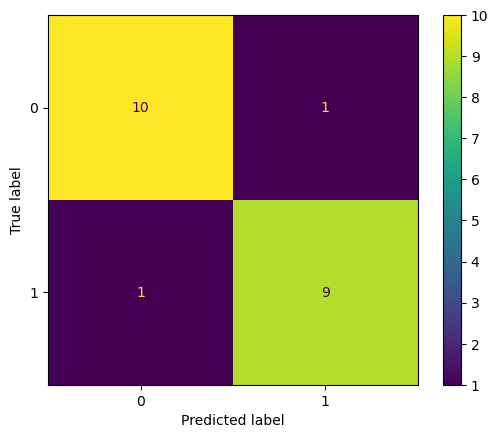

In [32]:
ConfusionMatrixDisplay(confusion_matrix(y_test,ypreds_resnet152)).plot()

# MobileNet

In [33]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_mobilenet)}")
print(f"Precision: {precision_score(y_test,ypreds_mobilenet)}")
print(f"Recall: {recall_score(y_test,ypreds_mobilenet)}")
print(f"F1 Score: {f1_score(y_test,ypreds_mobilenet)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_mobilenet)}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC Score: 1.0


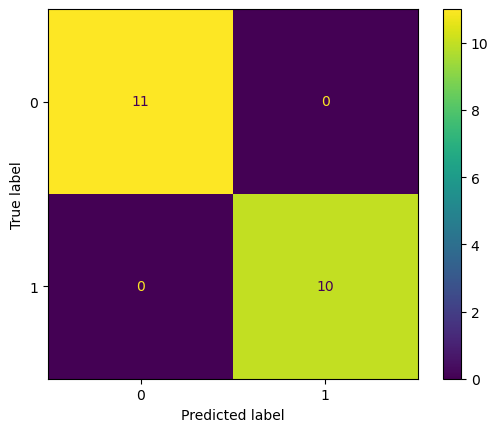

In [34]:
ConfusionMatrixDisplay(confusion_matrix(y_test,ypreds_mobilenet)).plot()

# InceptionNet

In [35]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_inception)}")
print(f"Precision: {precision_score(y_test,ypreds_inception)}")
print(f"Recall: {recall_score(y_test,ypreds_inception)}")
print(f"F1 Score: {f1_score(y_test,ypreds_inception)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_inception)}")

Accuracy: 0.6190476190476191
Precision: 0.6
Recall: 0.6
F1 Score: 0.6
ROC Score: 0.6181818181818183


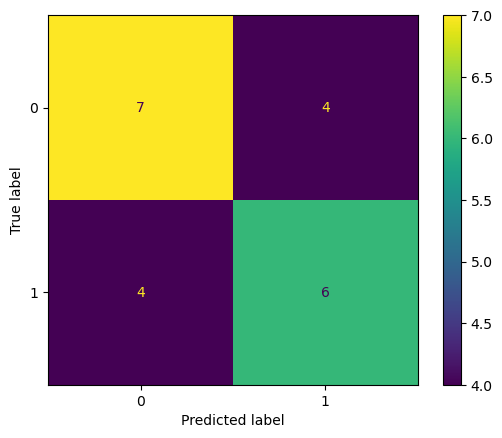

In [36]:
ConfusionMatrixDisplay(confusion_matrix(y_test,ypreds_inception)).plot()

# VGG

In [37]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_vgg19)}")
print(f"Precision: {precision_score(y_test,ypreds_vgg19)}")
print(f"Recall: {recall_score(y_test,ypreds_vgg19)}")
print(f"F1 Score: {f1_score(y_test,ypreds_vgg19)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_vgg19)}")

Accuracy: 0.8571428571428571
Precision: 1.0
Recall: 0.7
F1 Score: 0.8235294117647058
ROC Score: 0.85


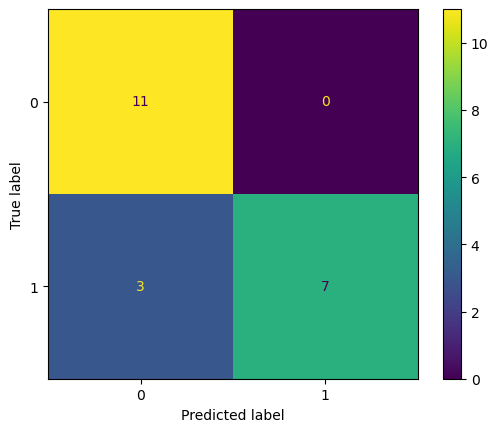

In [38]:
ConfusionMatrixDisplay(confusion_matrix(y_test,ypreds_vgg19)).plot()